## Notebook for visualizing chemical space in reduced dimensions

### Fig: 4c

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['figure.figsize'] = (4, 3)
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['ps.fonttype'] = 42
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as py
import colorsys
import os, sys
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer
from typing import List
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, PandasTools, rdMolDescriptors, Fragments
import optuna
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
from scipy.stats import rankdata
import scipy
from scipy.spatial.distance import pdist, squareform

In [ ]:
df = pd.read_csv('data_fig4c_tsne.csv')
df ## note: 'score' column refers to predicted eScore values for unlabeled compounds from eMolecules, PubChem, and GDB17 databases & to CE values for labeled compounds from literature (training & OOD)

,solv_comb_sm,score,database,tsne_0,tsne_1
0,N#CC(F)Cl,0.640642,emolecules,-40.520080,26.269161
1,CC(C#N)C#N,0.637202,emolecules,-39.789117,24.924783
2,COC(=O)C#N,0.632583,emolecules,-3.742554,49.067006
3,N#CC(F)F,0.631385,emolecules,-40.468889,26.255678
4,CC(=O)OC(C#N)C#N,0.625274,emolecules,-12.921387,76.461929
...,...,...,...,...,...
62547,CS(=O)(=O)OCC(F)(F)F,0.991400,known,-24.342435,5.672320
62548,FC(F)(F)C1COCO1,0.985000,known,47.847478,-27.333889
62549,FC(F)(F)COCCOCCOCC(F)(F)F,0.991411,known,-47.611665,-36.590871
62550,FCCOCCF,0.997000,known,-21.717168,-52.049601


In [4]:
emol = df.loc[df['database'] == 'emolecules']
pub = df.loc[df['database'] == 'pubchem']
gdb = df.loc[df['database'] == 'gdb17']
known = df.loc[df['database'] == 'known']
unknown = pd.concat([emol, pub, gdb], axis=0)
unknown

,solv_comb_sm,score,database,tsne_0,tsne_1
4636,CCN1CCOCC1,0.000000,emolecules,3.175537,-63.210487
4635,CC(C)C(=O)N1CCCC(C(=O)N2CCCC2)C1,0.466756,emolecules,56.750879,62.795759
4634,CC(C)C(=O)N1CCCN(C(=O)C(C)C)CC1,0.467290,emolecules,51.321451,61.465422
4633,CCOP(OCC)O[Si](C)(C)C,0.467305,emolecules,-26.018647,-73.093292
4632,CCOC1CSC2(C1)CN(C(=O)C(C)C)C2,0.467612,emolecules,58.449959,65.362709
...,...,...,...,...,...
59782,CCC1(OC(=O)C#N)OC(=O)CC1C(=O)C=O,0.581672,gdb17,114.741333,3.072549
59781,CCC1(S(=O)(=O)C=O)OC(=O)C(C#N)O1,0.585228,gdb17,110.732635,13.870191
59780,CC1CC(OC(=O)C#N)(C(=O)C=O)OC(=O)O1,0.587212,gdb17,113.299732,9.830026
59779,CC1OC(C#N)(C=O)C(C)(C#N)OC1=O,0.588744,gdb17,103.421275,-3.068476


In [3]:
df.sort_values('score', ascending=True, inplace=True)
df

,solv_comb_sm,score,database,tsne_0,tsne_1
4636,CCN1CCOCC1,0.000000,emolecules,3.175537,-63.210487
59777,CC(C)(C)N(CCC(C)(C)C(C)(C)C)S(C)(=O)=O,0.464021,pubchem,-15.231645,32.797865
59776,COC(C)CCO[Si](C)(C)C(C)(C)C,0.464027,pubchem,-59.542907,29.633317
62476,CCCOC(C)(C)C1OC(C)(C)C(C)C1CC,0.464110,gdb17,60.948591,-60.287914
59775,CCN(CC)P1(=S)SCCS1,0.464347,pubchem,-6.053659,-56.372787
...,...,...,...,...,...
62520,FC(F)COCCOCC(F)(F)F,0.995000,known,-48.879734,-35.445132
62541,COCC(OC)C(F)(F)F,0.996000,known,-78.945992,-35.863208
62497,CF,0.996500,known,-5.253914,-22.791264
62550,FCCOCCF,0.997000,known,-21.717168,-52.049601


In [5]:
known['score_1'] = known['score'].apply(lambda x: -np.log10(1-x))
known

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_46254/2760727266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known['score_1'] = known['score'].apply(lambda x: -np.log10(1-x))


,solv_comb_sm,score,database,tsne_0,tsne_1,score_1
62524,O=C1OCC(C(F)(F)F)O1,0.542000,known,106.568050,30.640136,0.339135
62532,CCCCCC[Si](OC)(OC)OC,0.857000,known,-6.005348,-96.562729,0.844664
62482,CC1COC(=O)O1,0.862000,known,101.636788,22.878708,0.860121
62500,COC(=O)OC,0.867542,known,-2.918249,85.351571,0.877921
62551,FCCOCCOCCOCCF,0.874748,known,-21.758317,-52.072518,0.902214
...,...,...,...,...,...,...
62520,FC(F)COCCOCC(F)(F)F,0.995000,known,-48.879734,-35.445132,2.301030
62541,COCC(OC)C(F)(F)F,0.996000,known,-78.945992,-35.863208,2.397940
62497,CF,0.996500,known,-5.253914,-22.791264,2.455932
62550,FCCOCCF,0.997000,known,-21.717168,-52.049601,2.522879


In [ ]:
def create_cmap(listval, color):
    vmin = min(listval)
    vmax = max(listval)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = mcolors.LinearSegmentedColormap.from_list('', [(norm(vmin), 'white'), (norm(vmax), color)])
    return cmap, norm

In [7]:
smiles = ['CCN1CCOCC1', 'COC(=O)C#N', 'CCS(=O)(=O)F', 'CCOCCS(=O)(=O)F', 'COCCOC', 'COCC(F)(F)C(F)(F)COC', 'FC(F)(F)COCCOCCOCC(F)(F)F']
std_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(sm)) for sm in smiles]

In [8]:
blue = (0, 0.576, 0.902) # 0, 147, 230
green = (0.349,0.745,0.306) # 89, 190, 78
red = (0.984, 0.262, 0.219) # 251, 67, 56 
orange = (0.984, 0.713, 0.305) # 251, 182, 78 
purple = (0.839, 0.286, 0.604) # 214, 73, 1541
anvil = (0.298, 0.78, 0.77) # 76, 199, 196
dark_purple = (0.557, 0, 0.998) # 142, 0, 252
pink = (0.95, 0.78, 0.996) # 242, 199, 154
gray = (0.463,0.463,0.463) # 118, 118, 118

#### t-SNE plot

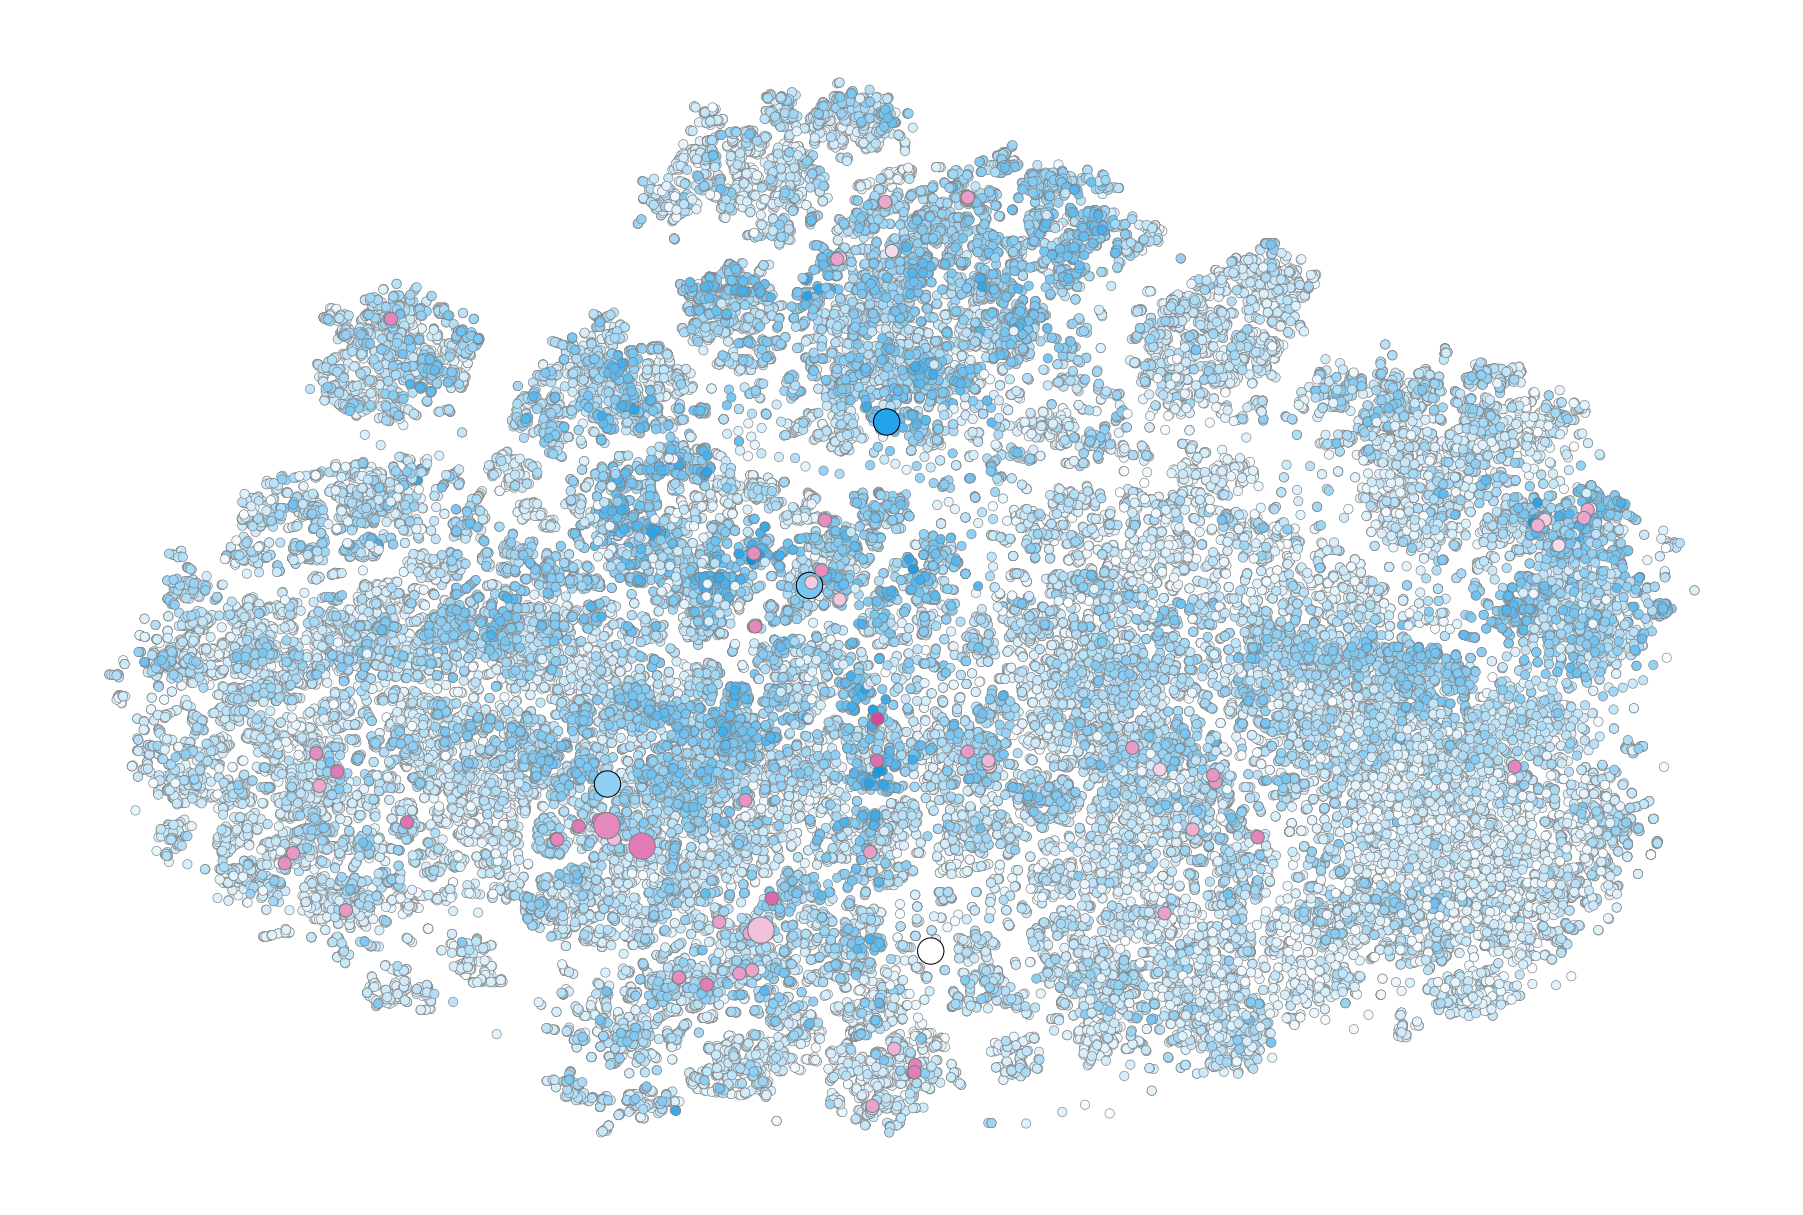

In [ ]:
fig, ax = plt.subplots(figsize=(7.5,5))

highlight_coords_1 = [tuple(row) for row in df.loc[df['solv_comb_sm'].isin(std_smiles[:4])][['tsne_0', 'tsne_1']].values]
highlight_coords_2 = [tuple(row) for row in df.loc[df['solv_comb_sm'].isin(std_smiles[4:])][['tsne_0', 'tsne_1']].values]

mask1_1 = ~unknown[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_1)
cmap1, norm1 = create_cmap(unknown[mask1_1]["score"], blue)  ## for unlabeled database
scatter1_1 = ax.scatter(unknown[mask1_1]["tsne_0"], unknown[mask1_1]["tsne_1"], c=unknown[mask1_1]["score"], s=5, cmap=cmap1, norm=norm1, label='Unlabeled', edgecolors='grey', linewidths=0.15)
mask1_2 = unknown[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_1)
scatter1_2 = ax.scatter(unknown[mask1_2]["tsne_0"], unknown[mask1_2]["tsne_1"], c=unknown[mask1_2]["score"], s=40, cmap=cmap1, norm=norm1, label='Unlabeled', edgecolors='black', linewidths=0.25)

cmap2, norm2 = create_cmap(known["score_1"], purple)  ## for literature set (over -log(1-CE) rather than CE to distinguish colors)
mask2_1 = ~known[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_2)
scatter2_1 = ax.scatter(known[mask2_1]["tsne_0"], known[mask2_1]["tsne_1"], c=known[mask2_1]["score_1"], s=10, cmap=cmap2, norm=norm2, label='Literature (CE)', edgecolors='gray', linewidths=0.25)
mask2_2 = known[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_2)
scatter2_2 = ax.scatter(known[mask2_2]["tsne_0"], known[mask2_2]["tsne_1"], c=known[mask2_2]["score_1"], s=40, cmap=cmap2, norm=norm2, label='Literature (CE)', edgecolors='gray', linewidths=0.25)

# fig.colorbar(scatter1_2, ax=ax, ticks=[0.45, 0.50, 0.55, 0.60, 0.65]) ## uncomment to visualize colorbar for unlabeled database
# fig.colorbar(scatter2_1, ax=ax) ## uncomment to visualize colorbar for literature set

plt.xticks([])
plt.yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
plt.savefig('plot_tsne_fig4c_020625.tiff', dpi=300, transparent=True)